In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing

print(tf.version.VERSION)
print(tf.keras.__version__)

import os
import sys

import numpy as np
#import tensorflow.numpy as np

2.0.0
2.2.4-tf


In [6]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import PlotUtils

In [14]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape, test_data.shape)
#print(train_targets)

(404, 13) (102, 13)


In [15]:
# prepare the data
# feature-wise normalization

def compute_mean_std(data):
    return (data.mean(axis=0), data.std(axis=0))

def normalize_data(data, mean, std):
    return (data - mean)/std
    

In [16]:
mean, std = compute_mean_std(train_data)

norm_train_data = normalize_data(train_data, mean, std)
norm_test_data = normalize_data(test_data, mean, std)


In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers

#configuring optimzers
from tensorflow.keras import optimizers
# custom losses and metrics
from tensorflow.keras import losses
from tensorflow.keras import metrics

from tensorflow.keras import regularizers

In [19]:
def build_model(input_shape=(norm_train_data.shape[1],)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    # ending layer has no activation, network can predict values from any range
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    # mean absolute Error: absolute value of the difference between the predictions and the targets
    
    return model

 K-fold validation
 It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating
 K identical models, and training each one on K – 1 partitions while evaluating on
 the remaining partition. The validation score for the model used is then the average of
 the K validation scores obtained. In terms of code, this is straightforward.

In [32]:
k = 4
num_val_samples = len(norm_train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = norm_train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [norm_train_data[:i * num_val_samples],
        norm_train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [34]:
print(all_scores)
print(np.mean(all_scores))

[2.2275672, 2.7149148, 2.5708637, 2.724337]
2.5594206


In [43]:
k = 4
num_val_samples = len(norm_train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    #Prepares the validation data:
    #data from partition #k
    val_data = norm_train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [norm_train_data[:i * num_val_samples],
        norm_train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    #print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


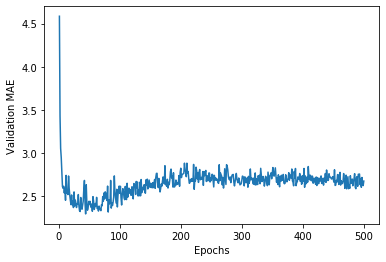

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [47]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1] # last
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



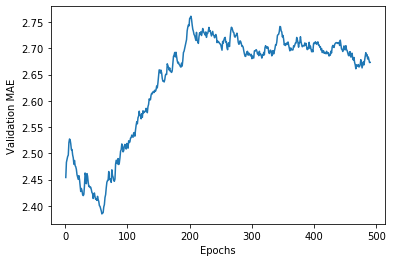

In [48]:
smoothed_mae_history = smooth_curve(average_mae_history[10:])

import matplotlib.pyplot as plt
plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

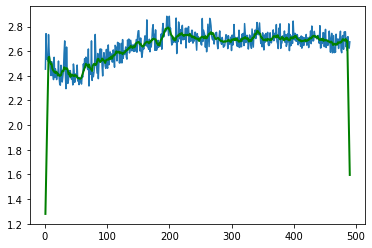

In [57]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#plot(x, y,'o')
#plot(x, smooth(y,3), 'r-', lw=2)
#plot(x, smooth(y,19), 'g-', lw=2)


#smoothed_mae_history = smooth_curve(average_mae_history[10:])


y = average_mae_history[10:]
smoothed_y = smooth(average_mae_history[10:], 10)
x = range(1, len(smoothed_y) + 1)

plt.plot(x, y)
#plt.plot(x, smooth(y,3), 'r-', lw=2)
plt.plot(x, smoothed_y, 'g-', lw=2)
#

Once you’re finished tuning other parameters of the model (in addition to the
number of epochs, you could also adjust the size of the hidden layers), you can train a
final production model on all of the training data, with the best parameters, and then
look at its performance on the test data.

In [49]:
model = build_model()
model.fit(norm_train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(norm_test_data, test_targets)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================